In [1]:
%load_ext autoreload
%autoreload 2

from mecha import networks
from mecha import response_optimization
from mecha import spectral

import numpy as np
import scipy as sp
import networkx as nx
import pandas as pd

from scipy.integrate import solve_ivp

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.colors import to_rgba, LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter

# import parula

import pickle

import seaborn as sns

In [2]:
cycle = [to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]

def flatten_alpha(over, under=np.array([1, 1, 1])):
    over = np.array(over)

    over_col = over[:3]
    over_alpha = over[3]

    return np.concatenate((over_col*over_alpha + under*(1 - over_alpha), [1.0]))

def sample_brillouin(netw, n_samples):
    a, b = netw.graph['periods']
    
    return [np.array([i*np.pi/a, j*np.pi/b])/(n_samples - 1) for i in range(n_samples) for j in range(n_samples)]

def sample_brillouin3d(netw, n_samples):
    a, b, c = netw.graph['periods']
    
    return [np.array([i*np.pi/a, j*np.pi/b, k*np.pi/c])/(n_samples - 1)
            for i in range(n_samples) for j in range(n_samples)
           for k in range(n_samples)]

def gap_sizes_2d(netw, k, opt, n_samples=21, sample_type='normal', sqrt=True,
                return_freqs=False):
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    a, b = netw.graph['periods']
    
    specs = []
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            q = np.array([qx, qy])
            spec = np.sort(samplefun(k, q))
        
            if sqrt:
                spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))
                
            # find gaps
            specs.append(spec)

    specs = np.array(specs)
    
    try:
        # Optimizer object
        uppers = specs[:,opt.gap_inds+1]
        lowers = specs[:,opt.gap_inds]
    except:
        # array of indices
        uppers = specs[:,opt+1]
        lowers = specs[:,opt]        
    
    min_upper = np.min(uppers, axis=0)
    max_lower = np.max(lowers, axis=0)
    
    if return_freqs:
        return min_upper - max_lower, min_upper, max_lower
    else:
        return min_upper - max_lower
    
def gap_sizes_3d(netw, k, opt, n_samples=11, sample_type='normal', sqrt=True,
                return_freqs=False):
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    a, b, c = netw.graph['periods']
    
    specs = []
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            for qz in np.linspace(-np.pi/c, np.pi/c, n_samples):
                q = np.array([qx, qy, qz])
                spec = np.sort(samplefun(k, q))

                if sqrt:
                    spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))

                # find gaps
                specs.append(spec)

    specs = np.array(specs)
    
    try:
        # Optimizer object
        uppers = specs[:,opt.gap_inds+1]
        lowers = specs[:,opt.gap_inds]
    except:
        # array of indices
        uppers = specs[:,opt+1]
        lowers = specs[:,opt]        
    
    min_upper = np.min(uppers, axis=0)
    max_lower = np.max(lowers, axis=0)
    
    if return_freqs:
        return min_upper - max_lower, min_upper, max_lower
    else:
        return min_upper - max_lower

def sample_spectrum_along(netw, k, q_initial, q_final, n_samples=40, sqrt=True, sample_type='normal'):
    q_vecs = (q_initial[:,np.newaxis] + (q_final[:, np.newaxis] - q_initial[:,np.newaxis])*np.linspace(0, 1, n_samples)).T
    
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    spectra = []
    for i in range(q_vecs.shape[0]):
        spec = samplefun(k, q_vecs[i,:])
        
        if sqrt:
            spec = np.sqrt(np.abs(spec))
        
        spectra.append(spec)
        
    dx = np.linalg.norm(q_vecs[1,:] - q_vecs[0,:])
    return np.array(spectra), q_vecs, dx

def sample_bz_spectrum_2d(netw, k, n_samples=31, sqrt=True, sample_type='normal'):
    a, b = netw.graph['periods']
    
    if sample_type == 'deformed':
        samplefun = netw.deformed_spectrum_at
    else:
        samplefun = netw.spectrum_at
    
    spectra = np.array([])
    for qx in np.linspace(-np.pi/a, np.pi/a, n_samples):
        for qy in np.linspace(-np.pi/b, np.pi/b, n_samples):
            q = np.array([qx, qy])
            spec = samplefun(k, q)
            
            if sqrt:
                spec = np.sign(spec + 1e-10)*np.sqrt(np.abs(spec))
                
            spectra = np.concatenate((spectra, spec))
            
    return spectra

def sample_bz_spectrum_3d(netw, k, n_samples=21, sqrt=True):
    a, b, c = netw.graph['periods']
    
    spectra = []
    for qx in np.linspace(0, np.pi/a, n_samples):
        for qy in np.linspace(0, np.pi/b, n_samples):
            for qz in np.linspace(0, np.pi/c, n_samples):
                q = np.array([qx, qy, qz])
                spec = netw.spectrum_at(k, q)

                if sqrt:
                    spec = np.sqrt(np.abs(spec))

                spectra.extend(spec)
            
    return spectra

def plot_spectrum(ax, netw, k, q_points, names, n_samples=20, sample_type='normal', show_gaps=None, 
                  gap_size=gap_sizes_2d, n_samples_gs=81, **kwargs):
    name_pts = [0]
    
    for i in range(len(q_points) - 1):
        spec, q_vecs, dx = sample_spectrum_along(netw, k, q_points[i], q_points[i+1], n_samples=n_samples,
                                                sample_type=sample_type)
        ax.plot(name_pts[i] + dx*np.linspace(0, 1, n_samples), spec, **kwargs)
    
        name_pts.append(name_pts[i] + dx)
    
    # plot gap in orange
    if show_gaps is not None:
        sz, upper, lower = gap_size(netw, k, show_gaps, return_freqs=True,
                                   n_samples=n_samples_gs)
        
        for l, u in zip(lower, upper):
            ax.fill_between([name_pts[0], name_pts[-1]], [l, l], [u, u],
                           color=cycle[1], alpha=0.4, zorder=-100)
    
    # plot separator lines
    for name_pt in name_pts[1:-1]:
        ax.axvline(name_pt, color='k', linewidth=0.66)
    
    # set ticks
    ax.set_xticks(name_pts)
    ax.set_xticklabels(names)
    ax.set_xlim(name_pts[0], name_pts[-1])
    ax.set_ylim(0)
    
    if show_gaps is not None:
        return lower, upper
    else:
        return None, None
    
def plot_result_2d(netw, k, ax_netw, ax_stiff, ax_bands, ax_dos, sample_type='normal', dos_bins=101,
                  show_gaps=None, factor=1, gs_bins=21):
    a, b = netw.graph['periods']

    Γ = np.array([0, 0])
    M = np.array([0, np.pi/b])
    X = np.array([np.pi/a, np.pi/b])
    blue_muchalpha = flatten_alpha((cycle[0][0], cycle[0][1], cycle[0][2], 0.2))   
    
    # Stiffness histogram
    if ax_stiff is not None:
        ax_stiff.hist(k, range=(0.1, 1.0), bins=21, density=False, histtype='step', orientation='horizontal')
        ax_stiff.set_xlabel('count')
        ax_stiff.xaxis.set_label_position('top') 
        ax_stiff.xaxis.set_ticks_position('top')
        ax_stiff.yaxis.set_label_position('right')
        ax_stiff.yaxis.set_ticks_position('right')
        ax_stiff.set_ylabel('stiffness $k$', labelpad=-12)
        ax_stiff.set_yticks([0.1, 1.0])
    
    # BZ spectrum
    if ax_dos is not None:
        bz_spec = sample_bz_spectrum_2d(netw, k, sample_type=sample_type)
        ax_dos.hist(bz_spec, bins=dos_bins, density=True, histtype='stepfilled',
                    facecolor=blue_muchalpha, edgecolor=blue_alpha, orientation='horizontal')
#         ax_dos.set_xlabel('ρ(ω)')
        ax_dos.set_ylabel(r"d.o.s. $\rho(\omega)$")
        ax_dos.set_ylim(0)
        ax_dos.yaxis.set_label_position('right')
        ax_dos.yaxis.set_ticks_position('right')
            
    # Network
    if ax_netw is not None:
        a, b = netw.graph['periods']
        netw.draw_edges_2d(factor*3*k, ax_netw, color=blue_alpha)
        ax_netw.set_xlim(0, a)
        ax_netw.set_ylim(0, b)
        ax_netw.set_xticks([])
        ax_netw.set_yticks([])

    # Band structure
    ls, us = plot_spectrum(ax_bands, netw, k, [M, Γ, X, M], ['M', 'Γ', 'X', 'M'], 
                  color=blue_alpha, linewidth=0.7, sample_type=sample_type,
                 show_gaps=show_gaps, n_samples_gs=gs_bins)
    ax_bands.set_ylabel('freq.', labelpad=-8)
    
    yticks = ax_bands.get_yticks()
    ax_bands.set_yticks([yticks[0], yticks[-2]])
    
    # mark the gap in the D.O.S.
    if show_gaps is not None and ax_dos is not None:
        ax_dos.set_xlim(*ax_dos.get_xlim())
        for l, u in zip(ls, us):
            ax_dos.fill_between([0, ax_dos.get_xlim()[1]], [l, l], [u, u], color=cycle[1],
                               alpha=0.4, zorder=-100)
            
    return ls, us

    
# default colors
blue = sns.color_palette()[0]
blue_alpha = (blue[0], blue[1], blue[2], 0.8)
spectrum_color = blue_alpha

In [3]:
np.random.seed(40)
delaunay = networks.DelaunayNetwork(dimension=2, n=36, copy_unit_cell=[0, 1])
delaunay = delaunay.make_periodic()

qs = sample_brillouin(delaunay, 3)

opt_delaunay = response_optimization.PointMassOptimizer(delaunay, [8], qs)

ret_delaunay = opt_delaunay.optimize(seed=42)
ret_delaunay

(      fun: 0.07317935560194007
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([-8.65040175e-04, -3.44730356e-03, -5.33694994e-03, -1.33647482e-03,
         1.98748133e-02, -9.41760512e-05,  1.04368144e-02, -3.22552590e-03,
        -3.95316843e-03, -3.03828305e-03, -4.51410168e-06, -1.62627220e-03,
        -9.82614445e-04, -2.92749405e-03, -1.46431222e-04,  8.15505030e-03,
        -1.16434417e-03,  1.28053795e-02, -1.94467468e-05, -6.14656106e-04,
        -7.02522051e-04, -8.52752252e-05, -1.01141424e-03, -2.13208017e-03,
        -5.16240968e-04, -2.56349061e-03,  1.05437533e-02, -1.80114805e-03,
        -3.25238317e-04, -2.63965423e-05,  1.06328183e-02,  2.43018371e-02,
         1.94816501e-02, -2.56734243e-04, -3.18864735e-05, -1.83730935e-04,
        -7.37907909e-04,  1.28312394e-02, -1.92020002e-04, -6.57226335e-04,
         1.05447008e-02, -2.71512313e-04,  2.10961371e-02, -9.41768030e-04,
        -4.42246739e-04, -9.24416767e-04,  6.21254591e-03,  

In [4]:
np.random.seed(40)
square = networks.TriangularGrid2D(n=6, m=6, x_periodic=True, y_periodic=True)

qs = sample_brillouin(square, 3)

opt_square = response_optimization.LaplacianOptimizer(square, [8], qs)

ret_square = opt_square.optimize(seed=42, lower_bound=1, upper_bound=10)
ret_square

(      fun: 0.03399964468147195
  hess_inv: <108x108 LbfgsInvHessProduct with dtype=float64>
       jac: array([ 2.02696622e-06, -9.62077023e-05, -1.46333408e-04, -6.89479125e-05,
         1.30212116e-04,  2.42131452e-04, -3.00798541e-05, -2.77303415e-05,
         1.33779879e-06, -1.16232161e-06, -2.14771445e-06,  1.40064075e-06,
        -3.57368975e-05,  2.91356791e-06, -1.33363721e-07,  9.26809010e-08,
         2.29267099e-04, -2.37745281e-04,  7.50874895e-05,  4.38225935e-05,
         7.82610725e-05,  2.95576891e-05,  1.50936765e-04, -1.40864709e-04,
         1.22655382e-04,  8.66879159e-07, -1.19467213e-04, -1.14515983e-04,
        -1.74977612e-04,  1.05014663e-04, -2.60531615e-04,  6.58663022e-05,
         1.63254317e-04, -5.99830461e-05, -1.28119912e-05, -3.76330211e-05,
        -1.44264031e-04, -7.23255064e-05, -1.02572388e-04, -9.03453916e-05,
        -1.34896842e-06, -3.20033117e-06, -3.59438001e-05, -5.76291181e-08,
        -1.06767662e-05,  3.47940585e-04, -7.77354271e-05, -

In [5]:
def lap_dynamical_matrix_at(self, k, q, return_matrices=False):
    """ Return the Laplacian at given wavevector
    """
    K = sp.sparse.diags(1/k)
    # Q = self.graph['Q']

    Q_q = self.incidence_matrix_ft(q)
    K_q = sp.sparse.eye(Q_q.shape[0]) + Q_q.dot(K).dot(Q_q.conj().transpose())

    if return_matrices:
        return K_q, Q_q
    else:
        return K_q
    
# redefine this function for Laplacians
square.dynamical_matrix_at = lambda *args, **kwargs: lap_dynamical_matrix_at(square, *args, **kwargs)

<IPython.core.display.Javascript object>


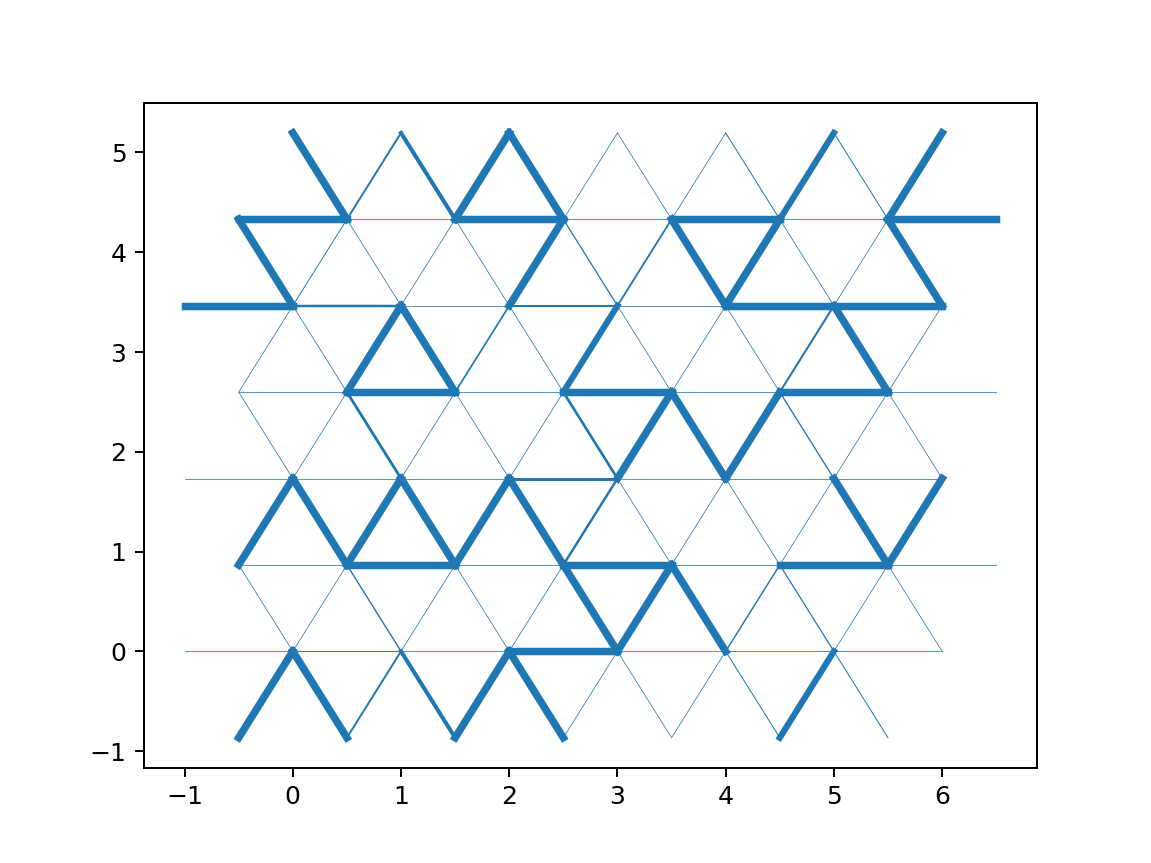

In [6]:
f, ax = plt.subplots()

# plot network
square.draw_edges_2d(3/ret_square[0].x, ax, color=blue);

# Figures v2

<IPython.core.display.Javascript object>


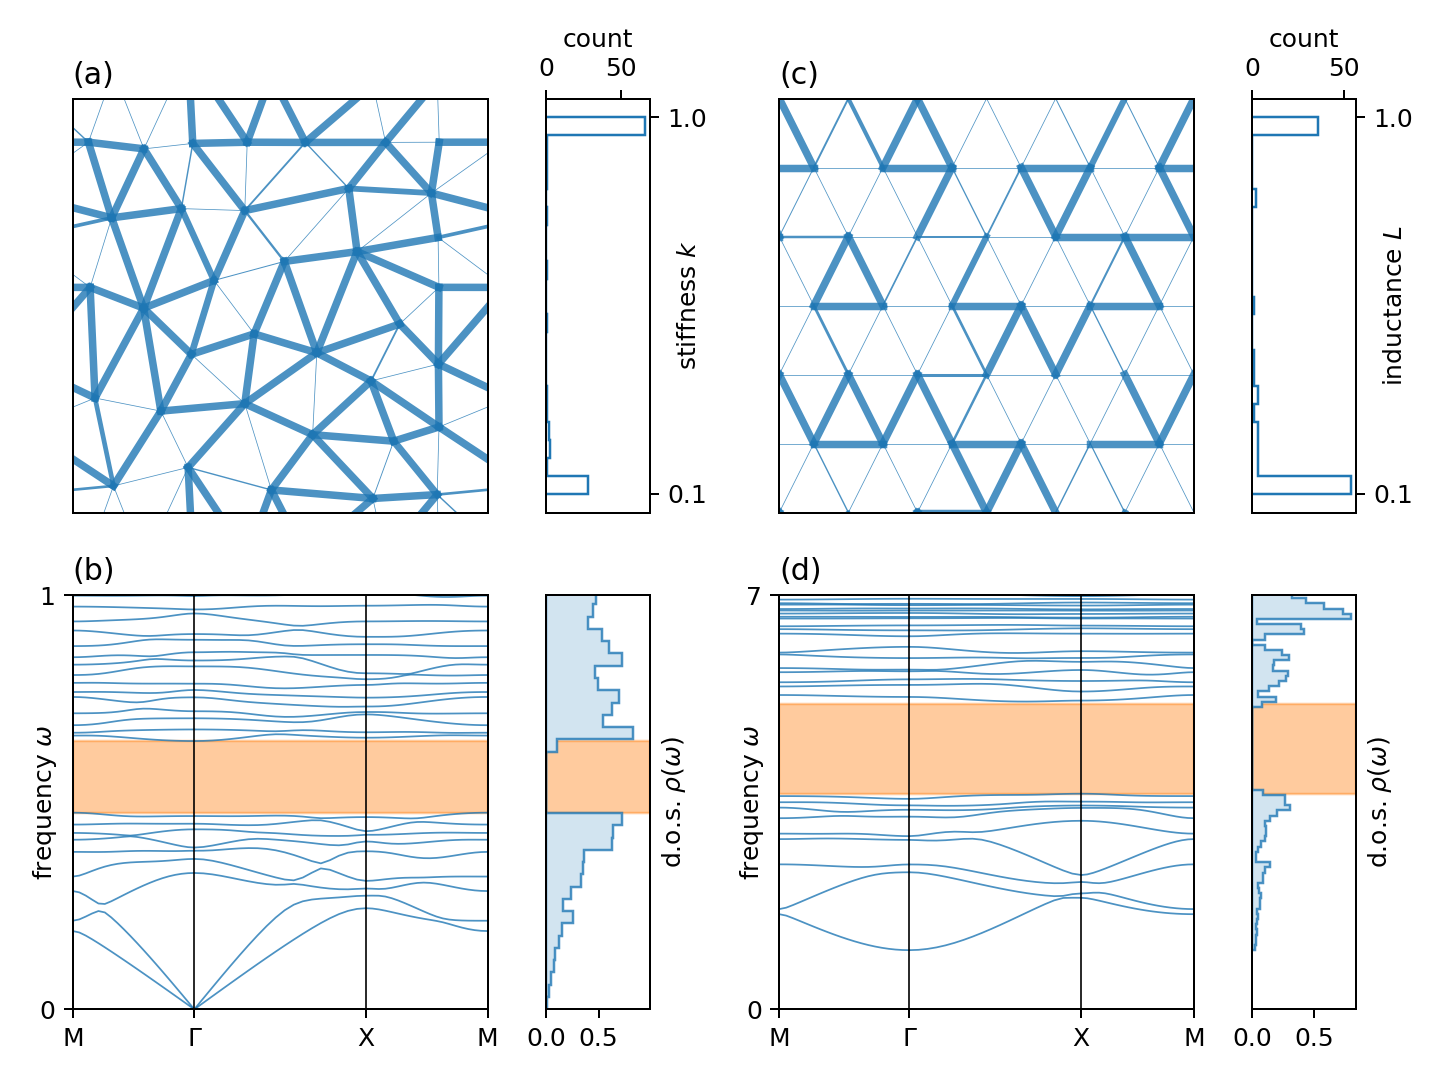

In [7]:
f = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(1, 2)

# Delaunay network
a, b = delaunay.graph['periods']

Γ = np.array([0, 0])
M = np.array([0, np.pi/b])
X = np.array([np.pi/a, np.pi/b])

gs0 = gridspec.GridSpecFromSubplotSpec(2, 2,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,0])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

ls_mech, us_mech = plot_result_2d(delaunay, ret_delaunay[0].x, ax_netw, ax_stiff, ax_bands, ax_dos,
              show_gaps=opt_delaunay.gap_inds, dos_bins=81, gs_bins=81)

ax_dos.set_yticks([])

ax_netw.set_title('(a)', loc='left')

ax_bands.set_ylim([0, 1.])
ax_bands.set_yticks([0, 1])
ax_bands.set_ylabel('frequency $\omega$')
ax_bands.set_title('(b)', loc='left')


ax_dos.set_ylim([0, 1.])



# Electrical network
a, b = delaunay.graph['periods']

Γ = np.array([0, 0])
M = np.array([0, np.pi/b])
X = np.array([np.pi/a, np.pi/b])

gs0 = gridspec.GridSpecFromSubplotSpec(2, 2,
                                       width_ratios=[4,1],
                                       subplot_spec=gs[0,1])
ax_netw = plt.subplot(gs0[0,0])
ax_stiff = plt.subplot(gs0[0,1])
ax_bands = plt.subplot(gs0[1,0])
ax_dos = plt.subplot(gs0[1,1])

ls_el, us_el = plot_result_2d(square, 1/ret_square[0].x, ax_netw, ax_stiff, ax_bands, ax_dos,
              show_gaps=opt_square.gap_inds, dos_bins=81, gs_bins=81,
              factor=1)


ax_netw.set_title('(c)', loc='left')

ax_stiff.set_ylabel("inductance $L$")

ax_bands.set_ylim([0, 7.])
ax_dos.set_ylim([0, 7.])
ax_dos.set_yticks([])

ax_bands.set_yticks([0, 7.])
ax_bands.set_ylabel('frequency $\omega$')
ax_bands.set_title('(d)', loc='left')


f.tight_layout()

f.savefig('figures/fig_1.pdf', dpi=300, bbox_inches='tight')
# f.savefig('figures/fig_1.eps', dpi=300, bbox_inches='tight')
f.savefig('figures/fig_1.svg', dpi=300, bbox_inches='tight')

In [8]:
# large, active network
k = ret_delaunay[0].x

ca, cb = 3, 3
new, k_new = delaunay.tile_unit_cell_2d(k, ca, cb)

k_s = ret_square[0].x
new_sq, k_new_sq = square.tile_unit_cell_2d(k_s, ca, cb)

In [9]:
# Mechanical network

N = 2*new.number_of_nodes()
nn = new.number_of_nodes()
K = new.stiffness_matrix(k_new)

α = 0.1
γ = 0.1

γf = 0.2
v = 1.0

β = 0.1
μ = 0.2

def f_active(t, y):
    u = y[:N]
    udot = y[N:]
    
    ux_dot = y[N:N+nn]
    uy_dot = y[N+nn:]
    
    udot_sqr = ux_dot**2 + uy_dot**2
    udot_sqr = np.concatenate((udot_sqr, udot_sqr))
    
    dy = np.zeros(y.shape)
    dy[:N] = udot
    dy[N:] = -K.dot(u) -α*u - γ*udot + γf*(1 - udot_sqr/v)*udot
#     dy[N:] = -K.dot(u) -u - β*udot + μ*(1 - udot_sqr)*udot # dimensionless form
    
    return dy

In [10]:
# Electrical network
L = np.real(lap_dynamical_matrix_at(new_sq, 1/k_new_sq, np.array([0, 0])))
ε = 0.02
ρ = 0.01
ns = L.shape[0]

def f_vdp(t, y):
    V = y[:ns]
    Vdot = y[ns:]
    
    dy = np.zeros(y.shape)
    dy[:ns] = Vdot
    dy[ns:] = -L.dot(V) - ρ*Vdot + ε*(1 - V**2)*Vdot
    
    return dy


In [11]:
np.random.seed(0)

tspan = [0, 10000]
t_eval = np.linspace(0.25*tspan[1], tspan[1], 10000)

sol = solve_ivp(f_active, tspan, 1e-3*np.random.randn(2*N), t_eval=t_eval)

t_eval_vdp = np.linspace(0.25*tspan[1], tspan[1], 20000)
sol_vdp = solve_ivp(f_vdp, tspan, 1e-3*np.random.randn(2*ns), t_eval=t_eval_vdp)

<IPython.core.display.Javascript object>


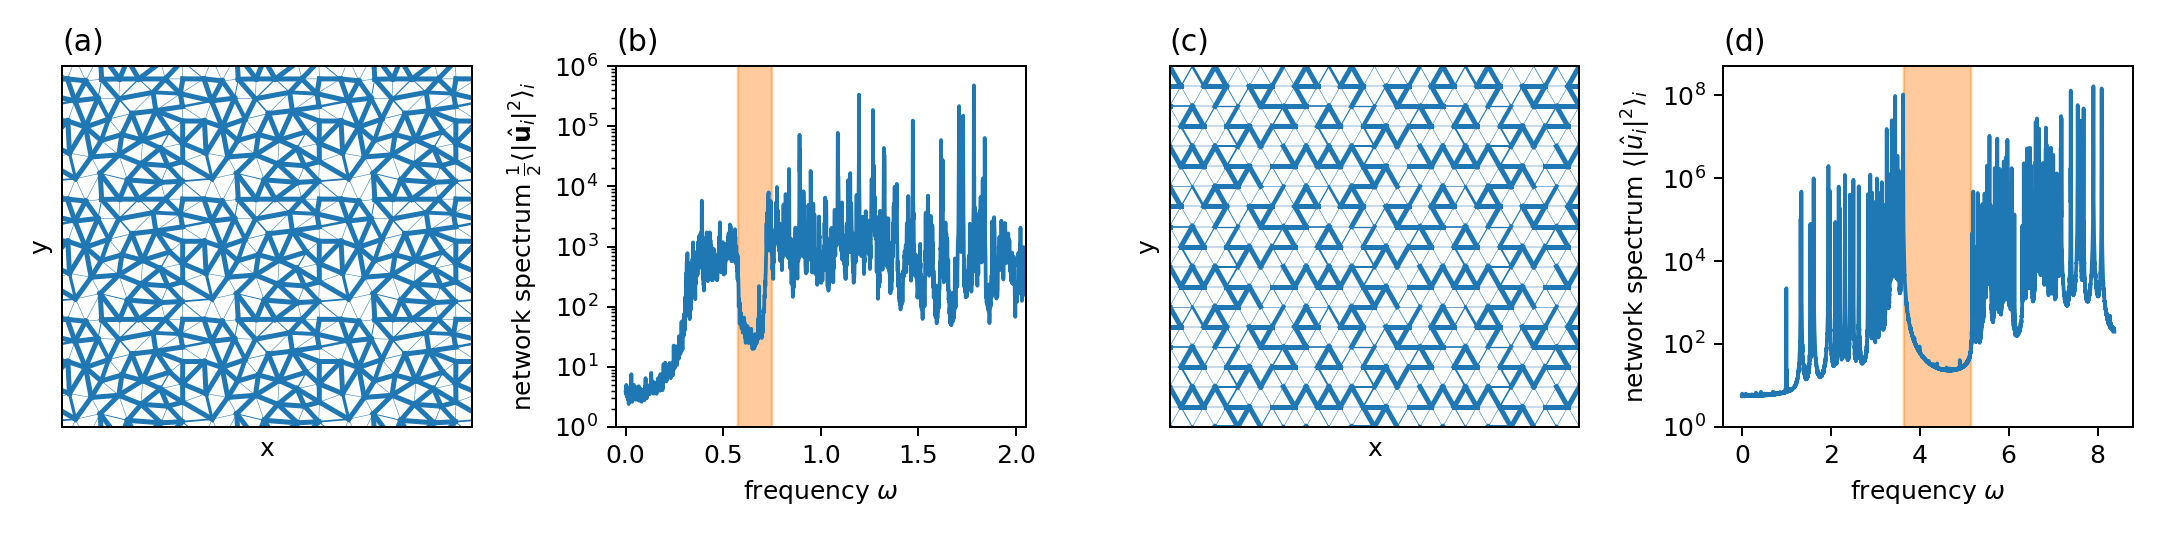

In [14]:
f, axs = plt.subplots(1, 4, figsize=(12, 3))

# ELASTIC NETWORK
# plot network
ax = axs[0]
new.draw_edges_2d(2*k_new, ax, color=blue)

# ax.axis("equal")
ax.set_xlim(0, ca)
ax.set_ylim(0, cb)
ax.set_title("(a)", loc="left")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks([])
ax.set_yticks([])

# plot spectral density
ax = axs[1]
spec = np.abs(np.fft.rfft(sol.y, axis=1))**2
freq = 2*np.pi*np.fft.rfftfreq(sol.y.shape[1], d=t_eval[1]-t_eval[0])

# ax.plot(sol.t, np.mean(sol.y**2, axis=0))
# ax.plot(sol.t, np.mean(sol.y, axis=0))

ax.semilogy(freq, np.mean(spec, axis=0))
ax.set_xlabel("frequency $\omega$")
ax.set_ylabel(r"network spectrum $\frac{1}{2}\langle |\hat{\mathbf{u}}_i|^2 \rangle_i$")
ax.set_title("(b)", loc="left")

ax.fill_betweenx([0, 1e7], ls_mech + α, us_mech + α, color=cycle[1], alpha=0.4)
ax.set_ylim(1e0, 1e6)
ax.set_xlim(-0.05, 2.05)


# ELECTRICAL NETWORK
# plot network
ax = axs[2]
new_sq.draw_edges_2d(2/k_new_sq, ax, color=blue)

# ax.axis("equal")
ax.set_xlim(0, ca*6)
ax.set_ylim(0, cb*6*np.sqrt(3)/2)
ax.set_title("(c)", loc="left")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xticks([])
ax.set_yticks([])

# plot spectral density
ax = axs[3]
spec = np.abs(np.fft.rfft(sol_vdp.y, axis=1))**2
freq = 2*np.pi*np.fft.rfftfreq(sol_vdp.y.shape[1], d=t_eval_vdp[1]-t_eval_vdp[0])

# ax.plot(sol.t, np.mean(sol.y**2, axis=0))
# ax.plot(sol.t, np.mean(sol.y, axis=0))

ax.semilogy(freq, np.mean(spec, axis=0))
ax.set_xlabel("frequency $\omega$")
ax.set_ylabel(r"network spectrum $\langle |\hat{u}_i|^2 \rangle_i$")
ax.set_title("(d)", loc="left")

ax.fill_betweenx([0, 1e9], ls_el, us_el, color=cycle[1], alpha=0.4)
ax.set_ylim(1e0, 5e8)

# ax.set_xlim(0, 1)
f.tight_layout()

f.savefig("figures/fig_2.pdf", bbox_inches="tight", dpi=300)
# f.savefig("figures/fig_2.eps", bbox_inches="tight", dpi=300)
f.savefig("figures/fig_2.svg", bbox_inches="tight", dpi=300)